## Experiments
In this section we provide the code for replicating the experiments from the paper.

### Simulation setup
We consider swarm of $n = 16$ drones initially distributed in a $4 \times 4$ grid formation. The function we are attemping to learn is the vertical component of the wind field in horizontal section of a cumulus formation. We simulate the cumulus inspired by the description provided in [1].

[1] <cite>Reymann, C., Renzaglia, A., Lamraoui, F., Bronz, M., & Lacroix, S. (2018). *Adaptive sampling of cumulus clouds with UAVs*. Autonomous Robots, 42(2), 491–512.</cite> [https://doi.org/10.1007/s10514-017-9625-1](https://doi.org/10.1007/s10514-017-9625-1)

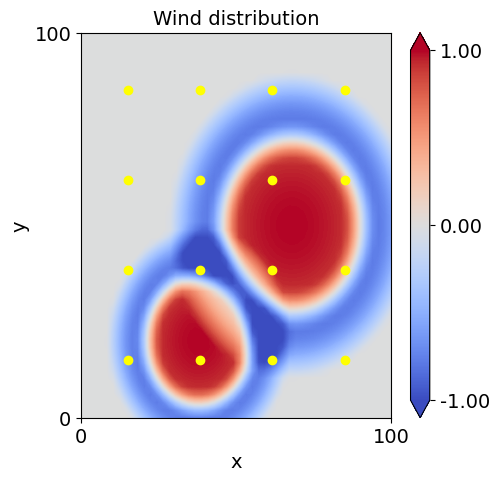

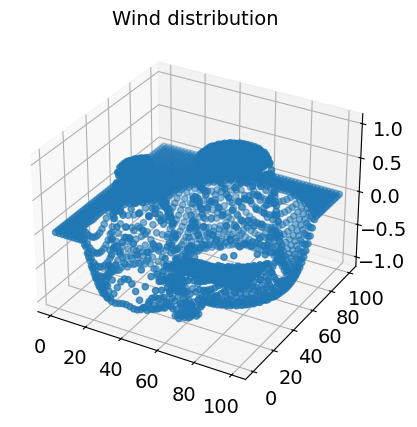

In [1]:
# GRID DRONE POSITION
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import copy

from utils import plot_mean, plot_var, plot_var_free, font_size

# Define the simulation area (e.g., a 2D grid)
area_size = 100

# Number of drones for each row, column
num_dronesx = 4
num_dronesy = 4

# Total number of drones
num_drones = num_dronesx * num_dronesy

# Distance of the grid from the border
margin = 15 / 100 * area_size

# Create a 3D grid for x, y, and z
x = np.linspace(margin, area_size - margin, num_dronesx)
y = np.linspace(margin, area_size - margin, num_dronesy)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y, z)
def reset_position():
    # Create a 3D grid for x, y, and z
    x = np.linspace(margin, area_size - margin, num_dronesx)
    y = np.linspace(margin, area_size - margin, num_dronesy)

    xv, yv = np.meshgrid(x, y)
    return copy.deepcopy(np.vstack([xv.ravel(), yv.ravel()]).T)

drone_positions = reset_position()

def wind_field_2d(pos, clouds, t, winds_current):
    """
    Calculates the wind speed in the range [-1, 1] at the point (x, y)
    based on the distribution of clouds.

    Parameters:
    - x, y: 2D coordinates to evaluate the wind
    - clouds: list of clouds, each defined by (cx, cy, radius),
              where (cx, cy) is the center of the cloud and
              radius is the size of the cloud.
    - t: the time step I'm evaluating the function at.
    - winds_current: list describing the wind velocity that moves the clouds, made by [vx, vy]

    Returns:
    - wind: Vertical wind velocity at point (x, y) in the range [-1, 1].
    """

    # Initialize wind velocity
    x = pos[:,0]
    y = pos[:,1]
    # Iterate over each cloud
    for cloud in clouds:
        cx, cy, radius, height = cloud
        cx += winds_current[0]*t*0.03
        cy += winds_current[1]*t*0.03

        # Calculate horizontal distance from the cloud center
        horizontal_distance = np.sqrt((x - cx)**2 + (y - cy)**2)

        # 1. Updraft (center of the cloud) - strongest at the center and reduces outward
        wind_Updraft = np.where(horizontal_distance <= (radius*0.4) , np.exp(-(horizontal_distance**2) / (2 * radius**2)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft = np.where(np.logical_and(horizontal_distance > (radius*0.4), horizontal_distance <= (radius*0.7)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * np.cos((horizontal_distance - (radius*0.4))*np.pi/(radius*0.3)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft += np.where(np.logical_and(horizontal_distance > (radius*0.7), horizontal_distance <= (radius)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * (-1)* np.cos((horizontal_distance - (radius*0.7))*np.pi/(2*radius*0.3)), 0)

        # Sum up the wind contributions from all clouds
        try:
          wind += wind_Updraft + wind_Downdraft
        except:
          wind = wind_Updraft + wind_Downdraft
    # Clamp the wind velocity to be within the range [-1, 1]
    return np.clip(wind, -1, 1)

clouds_2d = [
    (50, 50, 40, 10),
    (20, 20, 30, 10),
]
wind_direction_clouds = np.array([1,0])

sigma_nu = 0.1 # Standard deviation of measurement noise

x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Calculate the true function values
Z_true = wind_field_2d(XY, clouds_2d, 600, wind_direction_clouds).reshape(X.shape)

# Plot the true values
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_mean(ax, X, Y, Z_true, drone_pos=[drone_positions[:, 0], drone_positions[:, 1]], title="Wind distribution")
plt.show()

# Plot the true values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z_true)
ax.tick_params(labelsize=font_size)
plt.title('Wind distribution', fontsize=font_size)
plt.show()



## Nystrom feature extractor
The class **model_E** implements the Nystrom approximation-based feature extractor.

In [2]:
# https://andrewcharlesjones.github.io/journal/nystrom-approximation.html ---theory

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

class model_E:
  def __init__(self, E, l, kernel=ConstantKernel(1e-2, constant_value_bounds="fixed") * RBF(1, length_scale_bounds="fixed"), seed = 0):
    self.E = E
    self.l = l
    np.random.seed(seed)

    self.samples = np.random.rand(self.l,2) * area_size
    self.kernel = kernel
    K = self.kernel(self.samples)
    U, D, V = np.linalg.svd(K)
    self.Lambda = np.diag(D[:E])
    self.G = U[:,:E]

  def check(self):
      x = np.linspace(0, 1, 3)*area_size
      y = np.linspace(0, 1, 3)*area_size
      xy = np.vstack((x,y)).T
      m = x.shape[0]
      print(xy.shape)

      eigenfunctions = np.zeros((self.E, m))
      eigenfunctions = self.G.T @ self.kernel(self.samples, xy)

      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      eigenvalues = self.Lambda

      K = eigenfunctions.T @ (eigenvalues) @ eigenfunctions
      print(K)

      try:
          np.linalg.cholesky(K)
          psd = True
          print("true")
      except np.linalg.LinAlgError:
          print("error")

  def __call__(self, t):
      #t must be a mx2 array
      m = t.shape[0]
      x = np.zeros((m,2))
      x = t
      Q, R = np.linalg.qr(self.G)
      self.G = Q
      eigenfunctions = np.zeros((self.E, m))
      eigenvalues = np.eye(self.E)
      eigenfunctions = self.G.T @ self.kernel(self.samples, x)
      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      eigenvalues = np.diag(diag)

      return eigenfunctions, eigenvalues


## Baseline agent
In this section we define a BaselineAgent class that implements the time-varying distributed method from [2].<br><br>
[2] <cite> D. Jang, J. Yoo, C. Y. Son, and H. J. Kim, *Fully distributed infor-
mative planning for environmental learning with multi-robot systems*</cite>,
[arXiv: 2112.14433, 2021](https://arxiv.org/abs/2112.14433).

In [3]:
class Baseline_Agent:
    def __init__(self, position, area_size, kernel, num_drones, E, sigma_nu=1e-2, seed = 0):
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.sigma_nu = sigma_nu
        self.X_train = []
        self.y_train = []
        self.E = E
        self.alpha = np.zeros((self.E, self.E))
        self.beta = np.zeros((self.E,1))
        self.model_e = model_E(self.E, self.E, kernel, seed)
        self.num_drones = num_drones
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

    def move(self, step_size=1.0):
        angle = np.random.uniform(0, 2 * np.pi)
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)

    def update_gp(self, x_train = None, y_train = None):
        if x_train is None and y_train is None:
          x_train = self.X_train
          y_train = self.y_train
          self.alpha = np.zeros((self.E, self.E))
          self.beta = np.zeros((self.E,1))
          # Vectorized computation of phi and lamb
          phi, lamb = self.model_e(np.vstack(x_train))
          phi_x = phi @ phi.T
          phi_x = (phi_x + phi_x.T) / 2

          self.alpha = phi_x
          self.beta = phi @ np.array(y_train)

    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        noise = np.random.normal(0,self.sigma_nu)
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds) + noise
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def moving_update(self, x_new, y_new, r=1):
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * (phi.T * y_new.flatten()).reshape((self.E,1))

    def predict(self, X):
      predict = np.zeros(X.shape[0])
      phi, lamb = self.model_e(X)
      predict = phi.T @ np.linalg.inv(self.alpha + self.sigma_nu**2  * np.linalg.inv(lamb)) @ self.beta
      return predict

    def variance(self, X):
      m = len(self.X_train)
      predict = np.zeros((X.shape[0],1))
      phi, lamb = self.model_e(X)
      # TODO: we do not take the inverse of lamb in the formula after sigma2**2 
      predict[:,0] = np.diag(phi.T @ np.linalg.solve(lamb, phi) - phi.T @ np.linalg.solve(self.alpha + self.sigma_nu**2 * lamb, self.alpha @ np.linalg.solve(lamb, phi)))
      return predict

# DistKP agent

Here we provide a more efficient and stable version of the Agent class from **01_introduction.ipynb**. This introduce a distributed kalman filter update during the learning process.

In [4]:
class DistKP_Agent:
    def __init__(self, position, area_size, kernel, E, sigma_w, sigma_nu, seed = 0):
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.X_train = []
        self.y_train = []
        self.E = E
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

        #Kalman filter parameters:
        self.theta = np.zeros((E,1))
        self.P = 1 * np.eye(E)
        self.sigma_w = sigma_w
        self.Q = self.sigma_w * np.eye(E)
        self.sigma_nu = sigma_nu

        np.random.seed(seed)
        #Nystrom Method
        self.points = np.random.rand(E, 2) * area_size

        # Compute the kernel matrix
        kernel_matrix = self.kernel(self.points, self.points)

        # Perform Singular Value Decomposition (SVD)
        U, S, Vt = np.linalg.svd(kernel_matrix)

        # Create the diagonal matrix of singular values
        Lambda_E = np.diag(S)
        self.U = U
        self.Lambda_E = Lambda_E

    def move(self, step_size=1.0):
        angle = np.random.uniform(0, 2 * np.pi)
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)

    def kalman_update(self, x, y):
      x_hat = self.theta
      P_hat = self.P + self.Q
      H = self.kernel(np.array([[x[0][0], x[0][1]]]), self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      R = self.sigma_nu**2 * np.eye(H.shape[0])
      K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + R)
      self.theta = x_hat + K @ (y[0] - H @ x_hat)
      self.P = (np.eye(len(self.theta)) - K @ H) @ P_hat

      return (np.eye(self.E) - K @ H), K

    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        noise = np.random.normal(0,self.sigma_nu)
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds) + noise
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def predict(self, X):
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      mu = phi @ self.theta
      return mu

    def variance(self, X):
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      sigma_squared = phi @ self.P @ phi.T
      return np.diag(sigma_squared)



Here, we define variables to store simulation data for later plotting.

In [5]:
simulation_results = {
    # DistKP
    "z_true_distkp": [],
    "z_pred_distkp": [],
    "v_pred_distkp": [],
    "mse_distkp": [],
    "smse_distkp": [],

    # Baseline
    "z_true_baseline": [],
    "z_pred_baseline": [],
    "v_pred_baseline": [],
    "mse_baseline": [],
    "smse_baseline": [],

    # Spatio-temporal GP
    "z_true_gp": [],
    "z_pred_gp": [],
    "v_pred_gp": [],
    "mse_gp": [],
    "smse_gp": [],

    # Inv. Var vs BLUE
    "z_true_comp": [],
    "z_inv_var": [],
    "v_inv_var": [],
    "z_blue": [],
    "v_blue": []
}

## Evolution of the mean and variance esimate
We compare DistKP and the baseline method from [2]. Both methods are distributed and we plot the estimate of drone 6 (all of the 16 drones follow the same trajectories in both simulations). 

The max distance of communication between the drones can be modified using the slider at the bottom.

In [6]:
import ipywidgets as widgets
max_distance = 100
slider = widgets.FloatSlider(value=max_distance, min=0, max=200, step=5, description="Max distance of communication:")
def update_param(x):
    global max_distance
    max_distance = x 

slider = widgets.FloatSlider(value=max_distance, min=0, max=200, step=1, description='l')

label = widgets.Label(value="Max distance of communication:")

widget_layout = widgets.VBox([label, slider])
widgets.interactive(update_param, x=slider)
display(widget_layout)

### DistKP

/tmp/ipykernel_56378/3194292386.py:113: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)



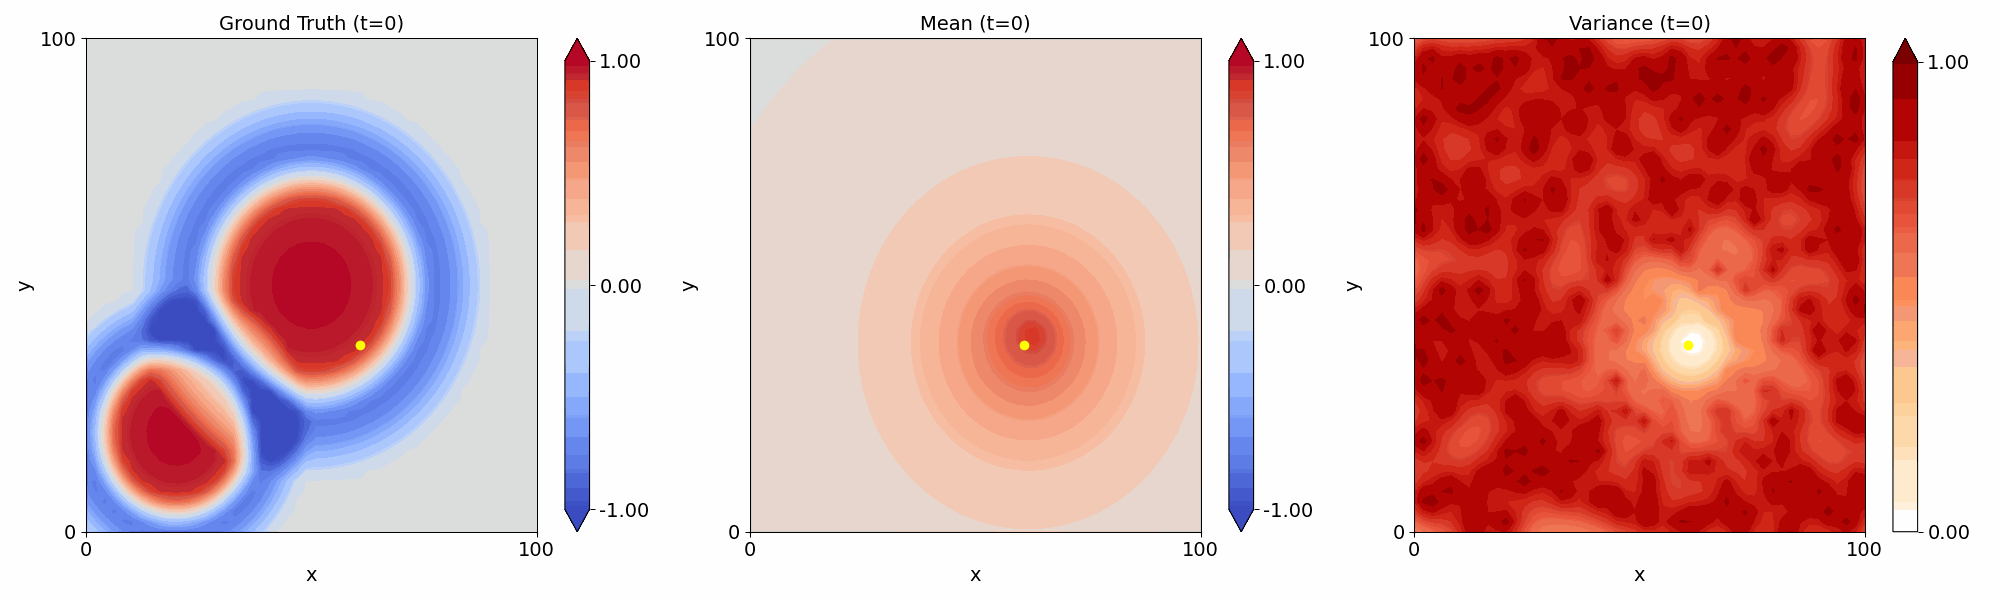

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import imageio
import io
import base64
from IPython.display import HTML

length_scale = 20
seed = 0

E = 300

sigma_w = 0.005

wind_direction_clouds = np.array([1,0])
drone_positions = reset_position()

kernel = Matern(length_scale, length_scale_bounds=(1e-05, 100.0), nu=0.5)

drones = [DistKP_Agent(position=drone_positions[i], area_size=area_size, kernel=kernel, E = E, sigma_w=sigma_w, sigma_nu=sigma_nu, seed = 0) for i in range(num_drones)]
# Create a 2D grid for x, y
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
# Calculate the true function values
wind = wind_field_2d(XY, clouds_2d, 0, wind_direction_clouds).reshape(xv.shape)

sample_points = []
sample_points_n = []

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

distkp_smse = []
distkp_mse = []

def build_matrix(drones):

  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones)
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  matrix = (adjacency_matrix + matrix)
  return matrix

# Build adjacency matrix:
adjacency = build_matrix(drones)

Ps = np.zeros((num_drones, E*E))
thetas = np.zeros((num_drones, E))

frames = []

for step in range(601):
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.kalman_update(X_new, y_new)
        drone.move()
  elif step % 1 == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        drone.kalman_update(X_new, y_new)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.move()
  else:
    for drone in drones:
        drone.move()

  if step % 50 == 0:
    Z_pred = drones[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)

    # Update simulation results
    simulation_results["z_true_distkp"].append(copy.deepcopy(Z_true))
    simulation_results["z_pred_distkp"].append(copy.deepcopy(Z_pred))
    simulation_results["v_pred_distkp"].append(copy.deepcopy(v_pred))

    # Ground Truth
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    plot_mean(ax[0], X, Y, Z_true, title=f'Ground Truth (t={step})', drone_pos=[drones[6].position[0], drones[6].position[1]])

    # Mean prediction
    plot_mean(ax[1], X, Y, Z_pred, title=f'Mean (t={step})', drone_pos=[drones[6].position[0], drones[6].position[1]])

    # Variance Prediction
    plot_var(ax[2], X, Y, v_pred, title=f'Variance (t={step})', drone_pos=[drones[6].position[0], drones[6].position[1]])

    plt.tight_layout()

    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Rewind buffer to the beginning

    # Read the image from the buffer and add to frames
    image = imageio.imread(buf)
    frames.append(image)

    buf.close()
    plt.close(fig)

    SMSE = np.mean((Z_pred - Z_true)**2/v_pred)
    MSE = np.mean((Z_pred - Z_true)**2)
    simulation_results["smse_distkp"].append(SMSE)
    simulation_results["mse_distkp"].append(MSE)

  adjacency = build_matrix(drones)
  for i in range(num_drones):
    Ps[i,:] = np.linalg.inv(drones[i].P).flatten()
    thetas[i,:] = (np.linalg.inv(drones[i].P) @ drones[i].theta).flatten()

  Ps = adjacency @ Ps
  thetas = adjacency @ thetas

  for i in range(num_drones):
    drones[i].P = np.linalg.inv(Ps[i,:].reshape((E,E))/np.sum(adjacency[i,:]))
    drones[i].theta = np.linalg.inv(Ps[i,:].reshape((E,E))) @ thetas[i,:].reshape((E,1))

# Create the GIF
imageio.mimsave('../figures/distkp_evolution.gif', frames, duration=500, loop=0)

with open("../figures/distkp_evolution.gif", "rb") as f:
  data = base64.b64encode(f.read()).decode('utf-8')

HTML(f'<img src="data:image/gif;base64,{data}" />')

### Algorithm from [18]

/tmp/ipykernel_56378/2223588746.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)



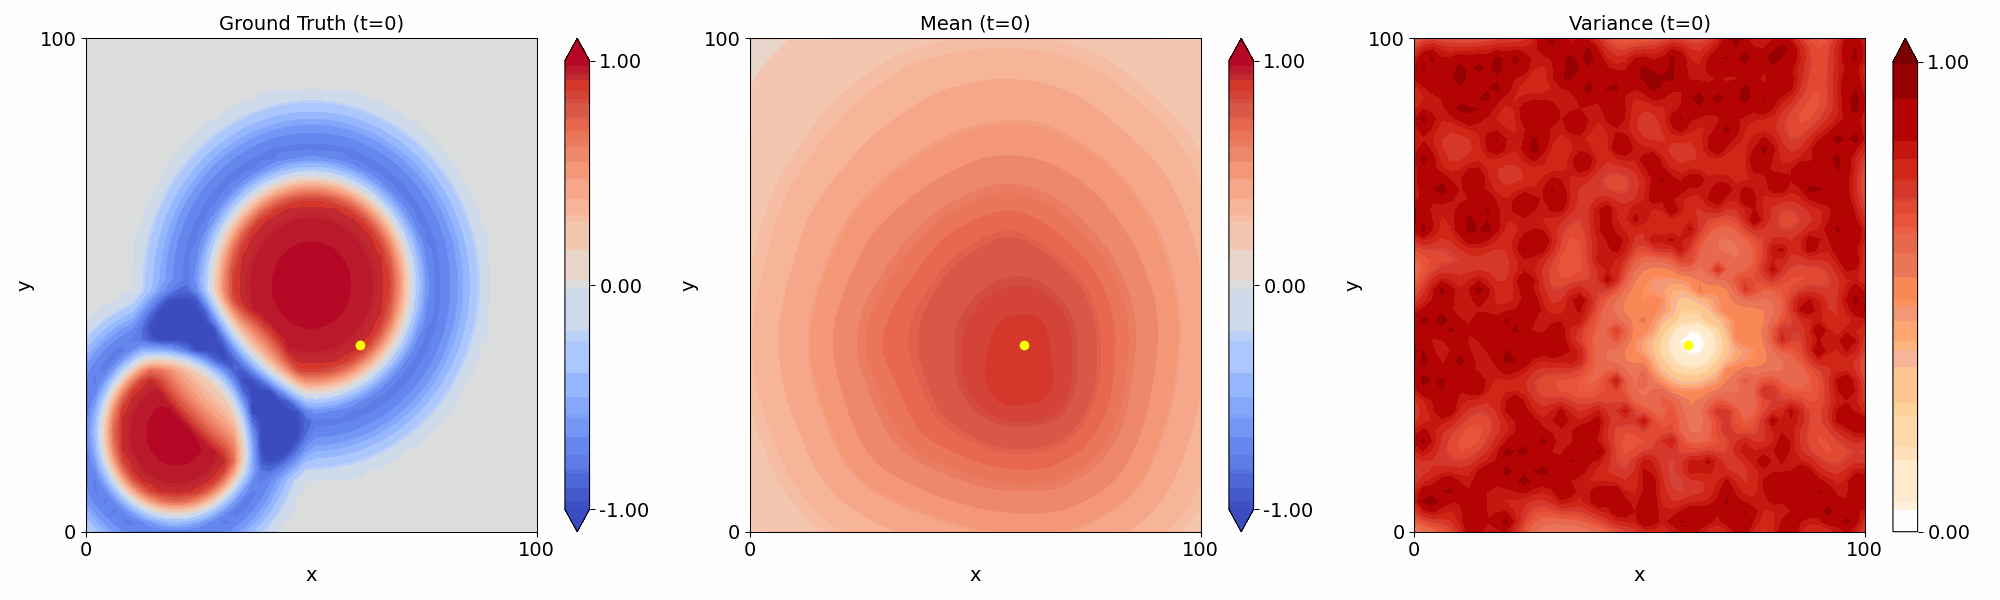

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors

seed = 0

E = 300

drone_positions = reset_position()

drones_noK = [Baseline_Agent(position=drone_positions[i], area_size=area_size, kernel=kernel, num_drones = 1, E = E, sigma_nu=sigma_nu) for i in range(num_drones)]

alphas = np.zeros((num_drones, E*E))
betas = np.zeros((num_drones, E))

baseline_smse = []
baseline_mse = []

def build_matrix(drones):
  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones)
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  matrix = (adjacency_matrix + matrix)
  return matrix

# Parameter of the IIR filter
r = 0.01

frames = []

for step in range(601):
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.update_gp()
        drone.move()
  elif step % 1 == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.moving_update(X_new, y_new, r = r)
        drone.move()
  else:
    for drone in drones_noK:
        drone.move()

  if step % 50 == 0:
    Z_pred = drones_noK[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    v_pred = drones_noK[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)

    # Update simulation results
    simulation_results["z_true_baseline"].append(copy.deepcopy(Z_true))
    simulation_results["z_pred_baseline"].append(copy.deepcopy(Z_pred))
    simulation_results["v_pred_baseline"].append(copy.deepcopy(v_pred))
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Ground Truth
    plot_mean(ax[0], X, Y, Z_true, title=f'Ground Truth (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    # Mean prediction
    plot_mean(ax[1], X, Y, Z_pred, title=f'Mean (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    # Variance Prediction
    plot_var(ax[2], X, Y, v_pred, title=f'Variance (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    plt.tight_layout()

    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Rewind buffer to the beginning

    # Read the image from the buffer and add to frames
    image = imageio.imread(buf)
    frames.append(image)

    buf.close()
    plt.close(fig)

    SMSE = np.mean((Z_pred - Z_true)**2/v_pred)
    MSE = np.mean((Z_pred - Z_true)**2)
    simulation_results["smse_baseline"].append(SMSE)
    simulation_results["mse_baseline"].append(MSE)

  adjacency = build_matrix(drones_noK)
  for i in range(num_drones):
    alphas[i,:] = drones_noK[i].alpha.flatten()
    betas[i,:] = drones_noK[i].beta.flatten()

  alphas_old = alphas.copy()
  betas_old = betas.copy()

  alphas = adjacency @ alphas / len(drones_noK)
  betas = adjacency @ betas / len(drones_noK)
  for i in range(num_drones):
    drones_noK[i].alpha = alphas[i,:].reshape((E,E))
    drones_noK[i].beta = betas[i,:].reshape((E,1))

# Create the GIF
imageio.mimsave('../figures/baseline_evolution.gif', frames, duration=500, loop=0)

with open("../figures/baseline_evolution.gif", "rb") as f:
  data = base64.b64encode(f.read()).decode('utf-8')

HTML(f'<img src="data:image/gif;base64,{data}" />')

### Centralized GP

Let's define a kernel operating only on a subset of the data-points dimensions (natively not avilable in scikit-learn).

In [9]:
from sklearn.gaussian_process.kernels import Kernel
import numpy as np

class DimensionKernel(Kernel):
    def __init__(self, base_kernel, dims):
        self.base_kernel = base_kernel
        self.dims = dims

    def __call__(self, X, Y=None, eval_gradient=False):
        X_sub = X[:, self.dims]
        Y_sub = Y[:, self.dims] if Y is not None else None
        return self.base_kernel(X_sub, Y_sub, eval_gradient=eval_gradient)

    def diag(self, X):
        return self.base_kernel.diag(X[:, self.dims])

    def is_stationary(self):
        return self.base_kernel.is_stationary()

    def __repr__(self):
        return f"{self.base_kernel} (dims={self.dims})"


Now we can define a time-separable spatio-temporal kernel.

In [10]:
length_scale = 20

sp_kernel = (
    DimensionKernel(Matern(length_scale, length_scale_bounds=(1e-05, 100.0), nu=0.5), np.array([1,2])) *
    DimensionKernel(RBF(length_scale=500), np.array([0])) # we use RBF for time variable since changes in time are smooth
)

/tmp/ipykernel_56378/1856433293.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)
/tmp/ipykernel_56378/1856433293.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)
/tmp/ipykernel_56378/1856433293.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)
/tmp/ipykernel_56378/1856433293.py:80: Depreca


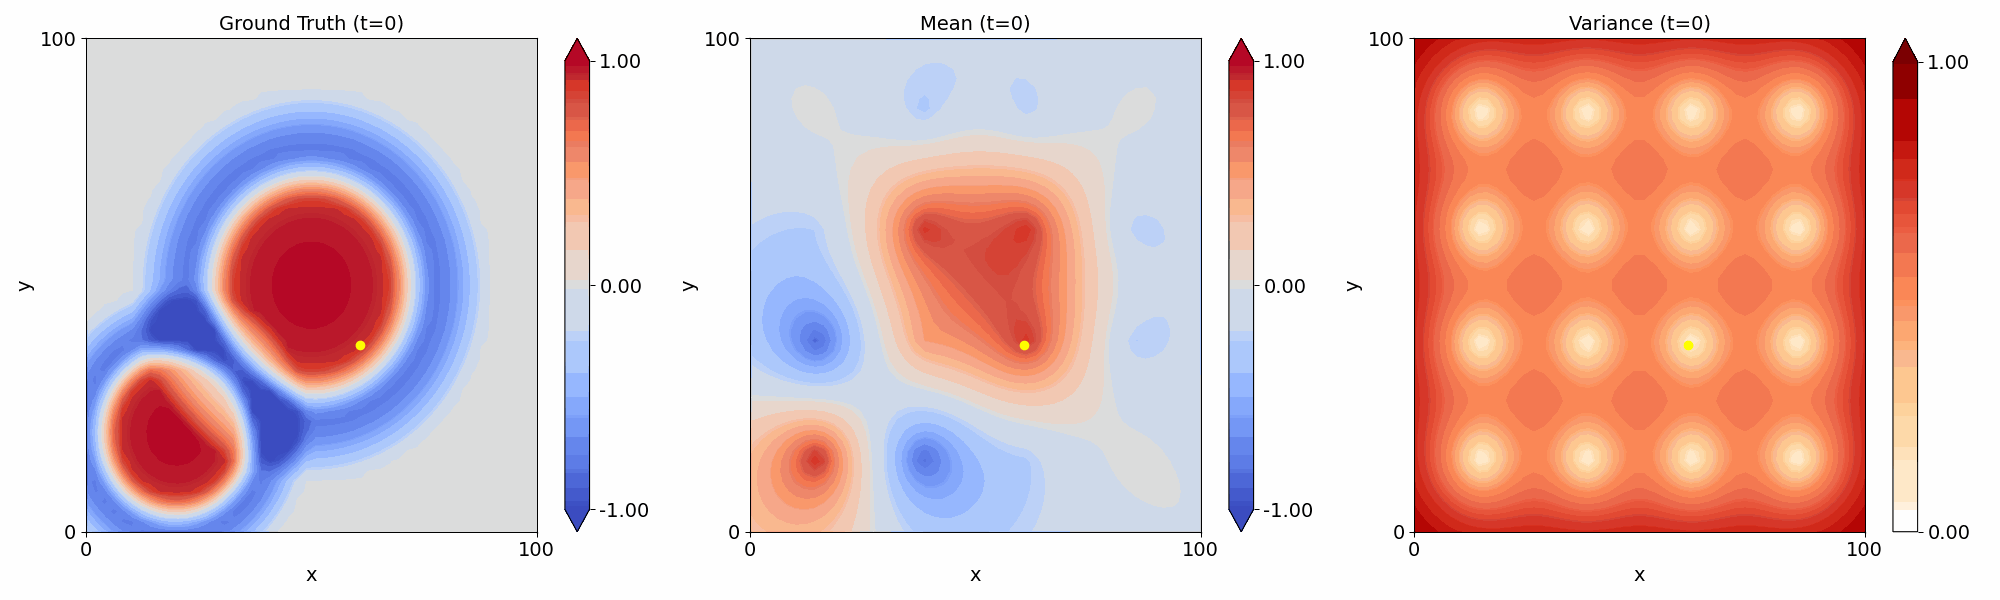

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors

seed = 0

E = 300

drone_positions = reset_position()

drones_noK = [Baseline_Agent(position=drone_positions[i], area_size=area_size, kernel=kernel, num_drones = 1, E = E) for i in range(num_drones)]

gp = GaussianProcessRegressor(kernel=sp_kernel, optimizer=None)

gp_smse = []
gp_mse = []

def build_matrix(drones):
  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones)
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  matrix = (adjacency_matrix + matrix)
  return matrix

dataset_X = np.empty((int(16*600) + 16, 3))
dataset_y = np.empty(int(16*600) + 16)

frames = []

for step in range(601):
  # Simulate the drones collecting data and updating the GP
  if step % 1 == 0:
    for i, drone in enumerate(drones_noK):
        X_new, y_new = drone.collect_data(step)
        dataset_X[16*step + i,:] = np.array([step, X_new[0,0], X_new[0,1]])
        dataset_y[16*step + i] = y_new[0]
        drone.move()
  else:
    for drone in drones_noK:
        drone.move()

  if step % 50 == 0:
    gp.fit(dataset_X[:16*step+16,:], dataset_y[:16*step+16])

    Z_pred, sigma = gp.predict(np.concat([step*np.ones((XY.shape[0],1)), XY], axis=1), return_std=True)
    Z_pred = Z_pred.reshape(X.shape)
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    v_pred = sigma**2
    v_pred = v_pred.reshape(X.shape)

    # Update simulation results
    simulation_results["z_true_gp"].append(copy.deepcopy(Z_true))
    simulation_results["z_pred_gp"].append(copy.deepcopy(Z_pred))
    simulation_results["v_pred_gp"].append(copy.deepcopy(v_pred))

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Ground Truth
    plot_mean(ax[0], X, Y, Z_true, title=f'Ground Truth (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    # Mean prediction
    plot_mean(ax[1], X, Y, Z_pred, title=f'Mean (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    # Variance Prediction
    plot_var(ax[2], X, Y, v_pred, title=f'Variance (t={step})', drone_pos=[drones_noK[6].position[0], drones_noK[6].position[1]])

    plt.tight_layout()

    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Rewind buffer to the beginning

    # Read the image from the buffer and add to frames
    image = imageio.imread(buf)
    frames.append(image)

    buf.close()
    plt.close(fig)

    SMSE = np.mean((Z_pred - Z_true)**2/v_pred)
    MSE = np.mean((Z_pred - Z_true)**2)
    simulation_results["smse_gp"].append(SMSE)
    simulation_results["mse_gp"].append(MSE)

# Create the GIF
imageio.mimsave('../figures/gp_evolution.gif', frames, duration=500, loop=0)

with open("../figures/gp_evolution.gif", "rb") as f:
  data = base64.b64encode(f.read()).decode('utf-8')

HTML(f'<img src="data:image/gif;base64,{data}" />')


### Numerical comparison via Standardized Mean Squared Error
In the problem that we are considering, that is time-varying regression where measurements are collected by moving agents, it is irrealistic to expect a high quality estimate over all the domain. After all, for this type of problems, a continuous exploration is required. For this reason, the Mean Squared Error (MSE), a metric that is often used for comparing regression algorithms, is not well suited for our setting. We instead adopt the ***Standardized*** **Mean Squared Error** (SMSE), where errors are weighted based on the predicted uncertainty
$$
    SMSE = \frac{1}{\mu(\mathcal{P})} \int_{\mathcal{S}} \frac{(y - y_{\text{true}})^2}{\sigma^2} \mathrm{d}\mathrm{x}.
$$
We compute an approximation to such metric by computing an average of the normalized errors at a set of uniformly distributed points
$$
    SMSE \approx \frac{1}{N_{\text{points}}} \sum_{i=1}^{N_{\text{points}}} \frac{(y - y_{\text{pred}})^2}{\sigma^2}.
$$

In [12]:
import pandas as pd

time = [k for k in range(0, 601, 50)]

baseline_mse = np.array(simulation_results["mse_baseline"])
baseline_smse = np.array(simulation_results["smse_baseline"])

distkp_mse = np.array(simulation_results["mse_distkp"])
distkp_smse = np.array(simulation_results["smse_distkp"])

gp_mse = np.array(simulation_results["mse_gp"])
gp_smse = np.array(simulation_results["smse_gp"])

smse = pd.DataFrame({
    't': time,
    'Baseline': baseline_smse,
    'DistKP': distkp_smse,
    'Centralized GP': gp_smse,
})

mse = pd.DataFrame({
    't': time,
    'Baseline': baseline_mse,
    'DistKP': distkp_mse,
    'Centralized GP': gp_mse,
})


### MSE

In [13]:
print("MSE table")
print(f"Baseline: Avg={round(np.mean(baseline_mse),2)}, Std={round(np.sqrt(np.mean((baseline_mse-np.mean(baseline_mse))**2)),2)}")
print(f"DistKP: Avg={round(np.mean(distkp_mse),2)}, Std={round(np.sqrt(np.mean((distkp_mse-np.mean(distkp_mse))**2)),2)}")
print(f"Centralized GP: Avg={round(np.mean(gp_mse),2)}, Std={round(np.sqrt(np.mean((gp_mse-np.mean(gp_mse))**2)),2)}")
mse

MSE table
Baseline: Avg=0.29, Std=0.15
DistKP: Avg=0.15, Std=0.07
Centralized GP: Avg=0.1, Std=0.03


t  Baseline    DistKP  Centralized GP
0     0  0.575345  0.315400        0.195646
1    50  0.270890  0.119462        0.109289
2   100  0.196914  0.115405        0.097934
3   150  0.182229  0.091094        0.089642
4   200  0.198181  0.084052        0.081425
5   250  0.160765  0.083241        0.067599
6   300  0.176568  0.089968        0.061028
7   350  0.147056  0.112561        0.062837
8   400  0.267516  0.167942        0.077550
9   450  0.464536  0.181245        0.083657
10  500  0.595530  0.207618        0.099772
11  550  0.277340  0.196323        0.107846
12  600  0.235297  0.214617        0.111258

### SMSE

In [14]:
print("SMSE Table")
print(f"Baseline: Avg={round(np.mean(baseline_smse),2)}, Std={round(np.sqrt(np.mean((baseline_smse-np.mean(baseline_smse))**2)),2)}")
print(f"DistKP: Avg={round(np.mean(distkp_smse),2)}, Std={round(np.sqrt(np.mean((distkp_smse-np.mean(distkp_smse))**2)),2)}")
print(f"Centralized GP: Avg={round(np.mean(gp_smse),2)}, Std={round(np.sqrt(np.mean((gp_smse-np.mean(gp_smse))**2)),2)}")
smse

SMSE Table
Baseline: Avg=0.59, Std=0.2
DistKP: Avg=0.41, Std=0.05
Centralized GP: Avg=0.43, Std=0.13


t  Baseline    DistKP  Centralized GP
0     0  0.800022  0.448683        0.376844
1    50  0.721231  0.489582        0.283430
2   100  0.524213  0.413576        0.296824
3   150  0.463467  0.315390        0.322240
4   200  0.493059  0.350397        0.331658
5   250  0.389700  0.352834        0.310720
6   300  0.406793  0.343077        0.338188
7   350  0.347919  0.366380        0.393888
8   400  0.550102  0.472125        0.496520
9   450  0.839166  0.435211        0.531108
10  500  1.077989  0.432699        0.611255
11  550  0.573233  0.433001        0.638326
12  600  0.490886  0.423616        0.646012

### Best Linear Unbiased Estimator (BLUE) vs Inverse Variance Weighting
In the following we compare DistKP's estimate averaging step, that makes use of a variation of Inverse Variance Weighting, and the (centrally computed) BLUE, a mathematically sound way to combine correlated measurements that cannot be implemented distributedly.

/tmp/ipykernel_56378/245896332.py:158: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)
/tmp/ipykernel_56378/245896332.py:205: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)



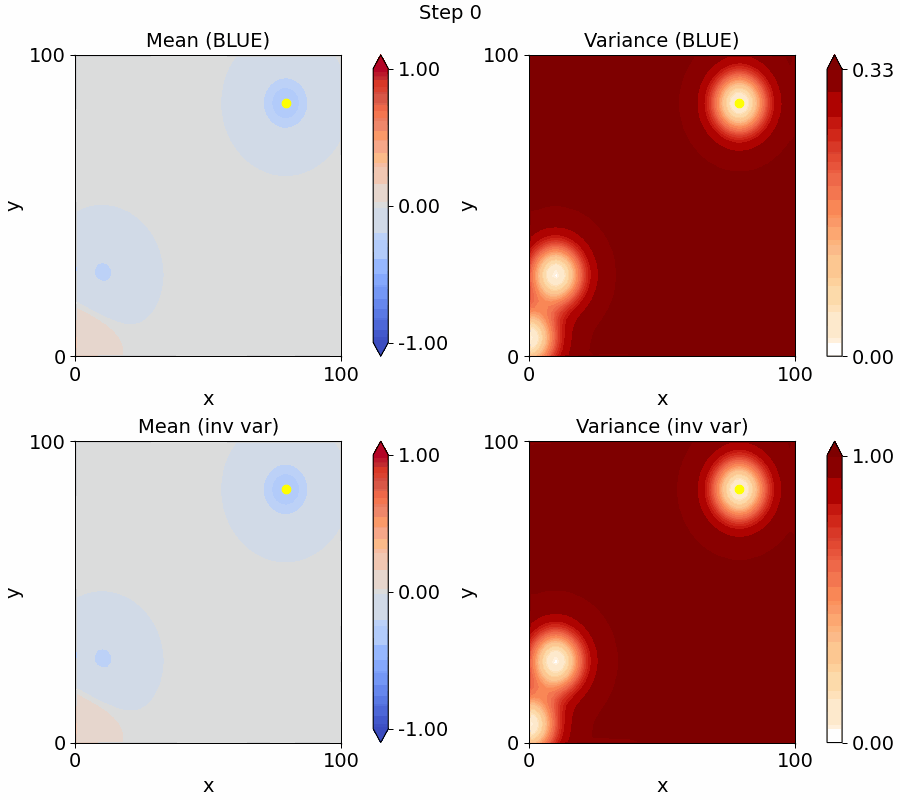

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern

np.set_printoptions(precision=2, suppress=False, formatter={'float': '{:0.2e}'.format})

low = -10
high = 10

sigma_s = 1e-1
length_scale = 10

sigma_w = 0

# Regularizing term for BLUE computation
reg = 1e-3

E = 300

num_drones = 5

init_pose = [np.array([10,10]), np.array([20,30]), np.array([40,50]), np.array([10,80]), np.array([70,80])]

# RBF
kernel_2 = RBF(length_scale=length_scale, length_scale_bounds="fixed")

drones = [DistKP_Agent(init_pose[i], area_size=area_size, kernel=kernel_2, E=E, sigma_w=0, sigma_nu=sigma_nu) for i in range(num_drones)]

drones_inv_var = [DistKP_Agent(init_pose[i], area_size=area_size, kernel=kernel_2, E=E, sigma_w=0, sigma_nu=sigma_nu) for i in range(num_drones)]

A = [[1, 1, 0, 0, 1],
     [1, 1, 0, 0, 0],
     [0, 0, 1, 1, 1],
     [0, 0, 1, 1, 0],
     [1, 0, 1, 0, 1]]
A = np.array(A)

V = np.eye(num_drones*E)
Theta = np.zeros((num_drones*E,1))

def communicate_BLUE(drones):
  global V, Theta, W

  W = np.zeros((num_drones*E, num_drones*E))
  for i in range(num_drones):
    N = [j for j in range(num_drones) if A[i,j]>0]
    # Compute local variables and covariance
    V_local = np.concatenate([np.concatenate([V[q*E:(q+1)*E,h*E:(h+1)*E] for h in N], axis=1) for q in N], axis=0)
    U_local = np.tile(np.eye(E), (len(N),1))
    # Perform local update
    V_local = V_local + reg*np.eye(len(N)*E)
    W_local = np.linalg.solve(U_local.T @ np.linalg.solve(V_local, U_local), U_local.T @ np.linalg.inv(V_local))
    for j in range(len(N)):
      W[i*E:(i+1)*E,N[j]*E:(N[j]+1)*E] = W_local[:,j*E:(j+1)*E]

  Theta = W @ Theta
  V = W @ V @ W.T

  for i in range(num_drones):
    drones[i].P = V[i*E:(i+1)*E, i*E:(i+1)*E]
    drones[i].theta = Theta[i*E:(i+1)*E,:]


def communicate_inv_var(drones):
  thetas = [drone.theta for drone in drones]
  Ps_inv = [np.linalg.inv(drone.P) for drone in drones]
  Ls = [P @ theta for theta,P in zip(thetas,Ps_inv)]
  Ps_inv_new = [sum([A[i,j] * Ps_inv[j] for j in range(num_drones)])/np.sum(A[i,:]) for i in range(num_drones)]
  Ls_new = [sum([A[i,j] * Ps_inv[j] @ thetas[j] for j in range(num_drones)])/np.sum(A[i,:]) for i in range(num_drones)]
  for i in range(num_drones):
    drones[i].P = np.linalg.inv(Ps_inv_new[i])
    drones[i].theta = drones[i].P @ Ls_new[i]

# Collect measurements and update the drones
np.random.seed(0)
step_size = 10 - 1
num_steps = 100
Q = np.eye(num_drones*E)
R = np.zeros((num_drones*E, num_drones*E))

frames = []

# We consider fixed clouds at t = 600
time_step = 600

for step_idx in range(num_steps):

  # BLUE drones

  Q = np.zeros((num_drones*E, num_drones*E))
  R = np.zeros((num_drones*E, num_drones*E))

  # Take a random step
  for i, drone in enumerate(drones):
    drone.move(step_size=10)
    drones_inv_var[i].position = copy.deepcopy(drone.position)

    # Collect measurement
    x, y = drone.collect_data(time_step)
    x, y = drones_inv_var[i].collect_data(time_step)

    # Update local parameters
    Q[i*E:(i+1)*E, i*E:(i+1)*E], K = drone.kalman_update(x,y)
    R[i*E:(i+1)*E, i*E:(i+1)*E] = sigma_s**2 * K @ K.T
    Theta[i*E:(i+1)*E] = drone.theta

    drones_inv_var[i].kalman_update(x,y)

  # Update global variables (parameter random drift)
  V = V + sigma_w**2 * np.tile(np.eye(E),(num_drones, num_drones))
  V = Q @ V @ Q.T + R

  # Communicate
  communicate_BLUE(drones)
  communicate_inv_var(drones_inv_var)

  if step_idx % 10 == 0:
    # BLUE predictions
    Z_Ny = drones[0].predict(XY)
    Var_Ny = drones[0].variance(XY)

    simulation_results["z_blue"].append(copy.deepcopy(Z_Ny))
    simulation_results["v_blue"].append(copy.deepcopy(Var_Ny))

    fig, axs = plt.subplots(2, 2, figsize=(9, 8), constrained_layout=True)

    # Top-left: Mean (BLUE)
    plot_mean(axs[0,0], X, Y, Z_Ny.reshape(X.shape), title="Mean (BLUE)", drone_pos=[drone.position[0], drone.position[1]])
    #for drone in drones:
    #  axs[0, 0].scatter(drone.pos[0][0], drone.pos[0][1], c=drone_color)

    # Top-right: Variance (BLUE)
    plot_var_free(axs[0,1], X, Y, Var_Ny.reshape(X.shape), title="Variance (BLUE)", drone_pos=[drone.position[0], drone.position[1]])

    # Inverse variance predictions
    Z_Ny_inv = drones_inv_var[0].predict(XY)
    Var_Ny_inv = drones_inv_var[0].variance(XY)

    simulation_results["z_inv_var"].append(copy.deepcopy(Z_Ny_inv))
    simulation_results["v_inv_var"].append(copy.deepcopy(Var_Ny_inv))

    # Bottom-left: Mean (inv var)
    plot_mean(axs[1,0], X, Y, Z_Ny_inv.reshape(X.shape), title="Mean (inv var)", drone_pos=[drone.position[0], drone.position[1]])

    # Bottom-right: Variance (inv var)
    plot_var(axs[1,1], X, Y, Var_Ny_inv.reshape(X.shape), title="Variance (inv var)", drone_pos=[drone.position[0], drone.position[1]])

    # Suptitle
    fig.suptitle(f"Step {step_idx}", fontsize=font_size)

    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Rewind buffer to the beginning

    # Read the image from the buffer and add to frames
    image = imageio.imread(buf)
    frames.append(image)

    buf.close()
    plt.close(fig)



# BLUE predictions
Z_Ny = drones[0].predict(XY)
Var_Ny = drones[0].variance(XY)

simulation_results["z_blue"].append(copy.deepcopy(Z_Ny))
simulation_results["v_blue"].append(copy.deepcopy(Var_Ny))

fig, axs = plt.subplots(2, 2, figsize=(9, 8), constrained_layout=True)

# Top-left: Mean (BLUE)
plot_mean(axs[0,0], X, Y, Z_Ny.reshape(X.shape), title="Mean (BLUE)", drone_pos=[drone.position[0], drone.position[1]])
#for drone in drones:
#  axs[0, 0].scatter(drone.pos[0][0], drone.pos[0][1], c=drone_color)

# Top-right: Variance (BLUE)
plot_var_free(axs[0,1], X, Y, Var_Ny.reshape(X.shape), title="Variance (BLUE)", drone_pos=[drone.position[0], drone.position[1]])

# Inverse variance predictions
Z_Ny_inv = drones_inv_var[0].predict(XY)
Var_Ny_inv = drones_inv_var[0].variance(XY)

simulation_results["z_inv_var"].append(copy.deepcopy(Z_Ny_inv))
simulation_results["v_inv_var"].append(copy.deepcopy(Var_Ny_inv))

# Bottom-left: Mean (inv var)
plot_mean(axs[1,0], X, Y, Z_Ny_inv.reshape(X.shape), title="Mean (inv var)", drone_pos=[drone.position[0], drone.position[1]])

# Bottom-right: Variance (inv var)
plot_var(axs[1,1], X, Y, Var_Ny_inv.reshape(X.shape), title="Variance (inv var)", drone_pos=[drone.position[0], drone.position[1]])

# Suptitle
fig.suptitle(f"Step {step_idx}", fontsize=font_size)

# Save the figure to a BytesIO buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)  # Rewind buffer to the beginning

# Read the image from the buffer and add to frames
image = imageio.imread(buf)
frames.append(image)

buf.close()
plt.close(fig)

# Create the GIF
imageio.mimsave('../figures/blue_vs_inv_var.gif', frames, duration=500, loop=0)

with open("../figures/blue_vs_inv_var.gif", "rb") as f:
  data = base64.b64encode(f.read()).decode('utf-8')

HTML(f'<img src="data:image/gif;base64,{data}" />')

## Figures
In the following we will generate the figures and tables from the paper

### Figure 1 - DistKP vs BLUE

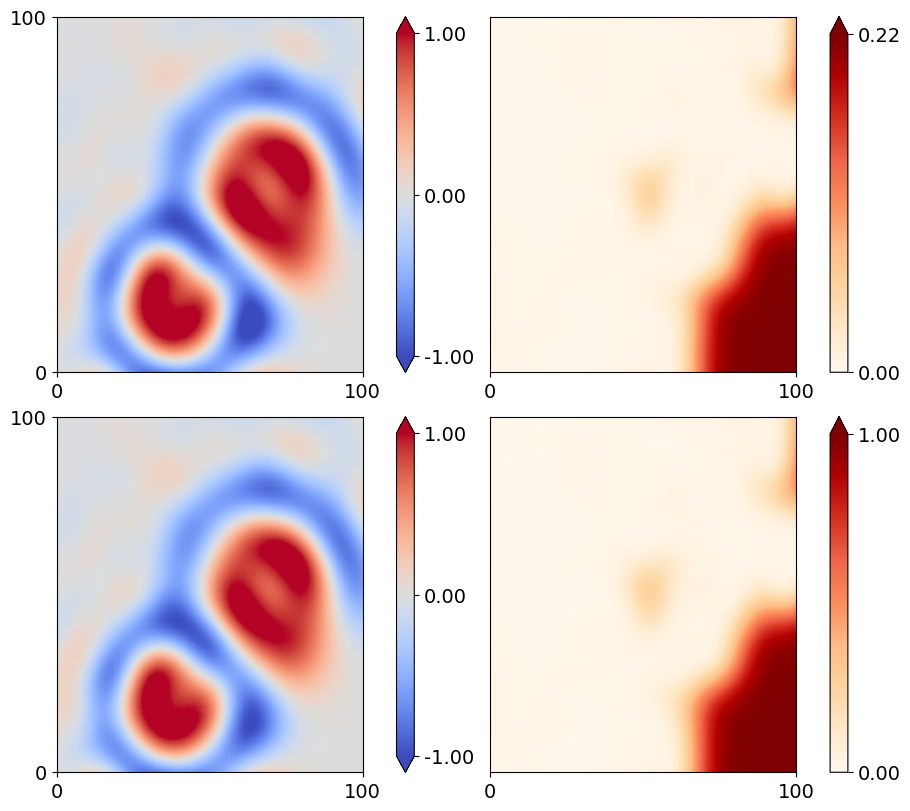

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8), constrained_layout=True)

# Top-left: Mean (BLUE)
plot_mean(ax[0,0], X, Y, simulation_results["z_blue"][-1].reshape(X.shape), plot_axes_labels=False)

# Top-right: Variance (BLUE)
plot_var_free(ax[0,1], X, Y, simulation_results["v_blue"][-1].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Bottom-left: Mean (inv var)
plot_mean(ax[1,0], X, Y, simulation_results["z_inv_var"][-1].reshape(X.shape), plot_axes_labels=False)

# Bottom-right: Variance (inv var)
plot_var_free(ax[1,1], X, Y, simulation_results["v_inv_var"][-1].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Save as PDF
plt.savefig("../figures/Figure-1.pdf", format="pdf", bbox_inches="tight")

plt.show()


### Figure 2 - Evolution of DistKP estimate

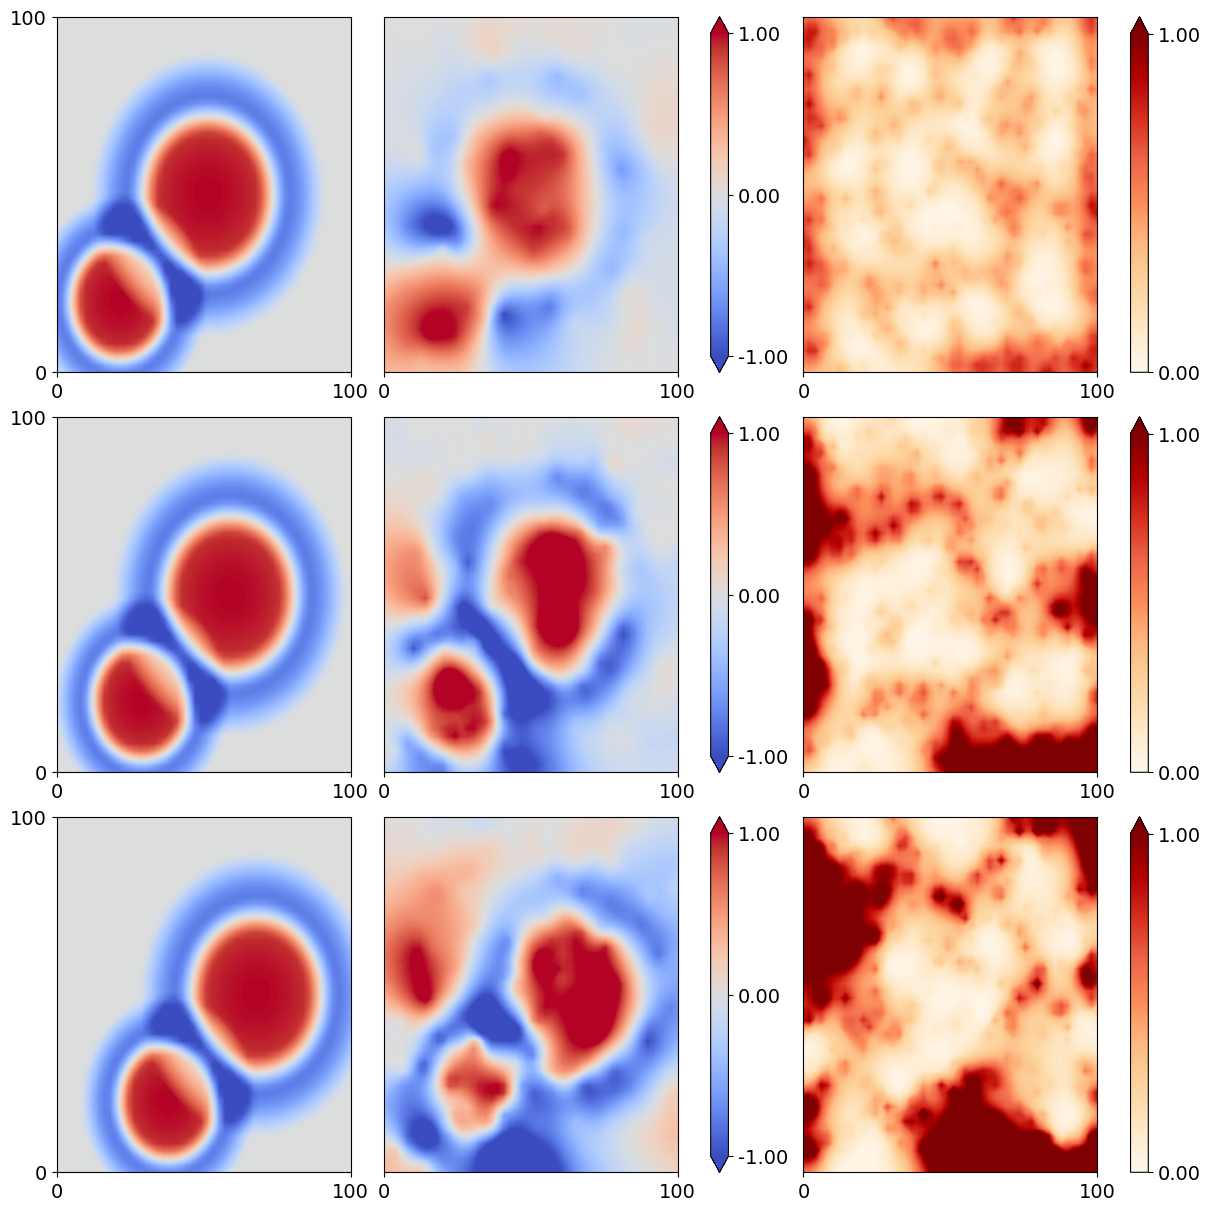

In [17]:

fig, ax = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)

# Top: t=50
plot_mean(ax[0,0], X, Y, simulation_results["z_true_distkp"][1].reshape(X.shape), plot_axes_labels=False, plot_cbar=False)
plot_mean(ax[0,1], X, Y, simulation_results["z_pred_distkp"][1].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)
plot_var(ax[0,2], X, Y, simulation_results["v_pred_distkp"][1].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Middle: t=300
plot_mean(ax[1,0], X, Y, simulation_results["z_true_distkp"][6].reshape(X.shape), plot_axes_labels=False, plot_cbar=False)
plot_mean(ax[1,1], X, Y, simulation_results["z_pred_distkp"][6].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)
plot_var(ax[1,2], X, Y, simulation_results["v_pred_distkp"][6].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Bottom-: t=600
plot_mean(ax[2,0], X, Y, simulation_results["z_true_distkp"][12].reshape(X.shape), plot_axes_labels=False, plot_cbar=False)
plot_mean(ax[2,1], X, Y, simulation_results["z_pred_distkp"][12].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)
plot_var(ax[2,2], X, Y, simulation_results["v_pred_distkp"][12].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Save as PDF
plt.savefig("../figures/Figure-2.pdf", format="pdf", bbox_inches="tight")

plt.show()


### Figure 3 - Comparison between DistKP, Baseline and Ground Truth

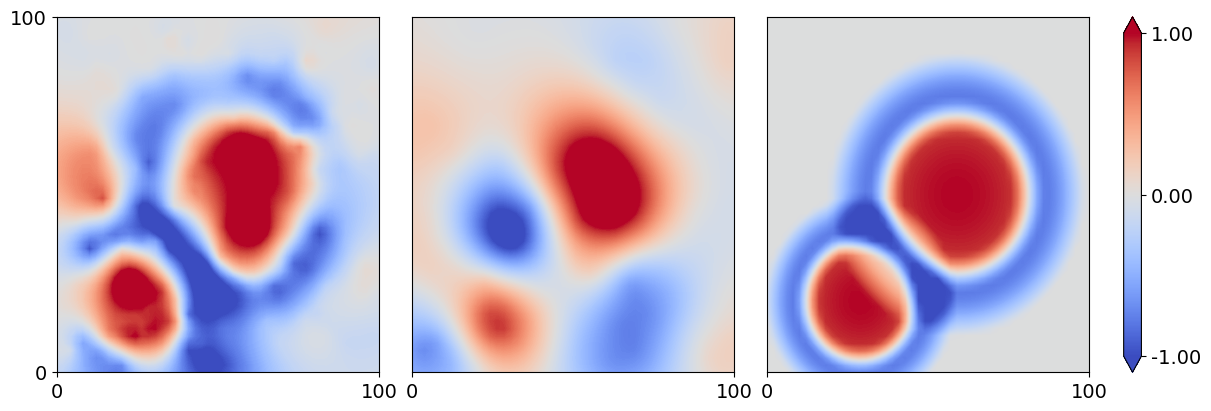

In [18]:

# Figure 3 - Comparison between DistKP, Baseline and Ground Truth
fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)


plot_mean(ax[0], X, Y, simulation_results["z_pred_distkp"][6].reshape(X.shape), plot_axes_labels=False, plot_cbar=False)
plot_mean(ax[1], X, Y, simulation_results["z_pred_baseline"][6].reshape(X.shape), plot_axes_labels=False, plot_cbar=False, plot_y_ticks=False)
plot_mean(ax[2], X, Y, simulation_results["z_true_distkp"][6].reshape(X.shape), plot_axes_labels=False, plot_y_ticks=False)

# Save as PDF
plt.savefig("../figures/Figure-3.pdf", format="pdf", bbox_inches="tight")

plt.show()


### Table 1 - MSE for DistKP, Baseline and Spatio-temporal GP

In [19]:

# Table 1 - MSE and SMSE for DistKP, Baseline and Spatio-temporal GP
time = [k for k in range(0, 601, 50)]

baseline_mse = np.array(simulation_results["mse_baseline"])
distkp_mse = np.array(simulation_results["mse_distkp"])
gp_mse = np.array(simulation_results["mse_gp"])

mse = pd.DataFrame({
    't': time,
    'Baseline': baseline_mse,
    'DistKP': distkp_mse,
    'Centralized GP': gp_mse,
})

print("MSE table")
print(f"Baseline: Avg={round(np.mean(baseline_mse),2)}, Std={round(np.sqrt(np.mean((baseline_mse-np.mean(baseline_mse))**2)),2)}")
print(f"DistKP: Avg={round(np.mean(distkp_mse),2)}, Std={round(np.sqrt(np.mean((distkp_mse-np.mean(distkp_mse))**2)),2)}")
print(f"Centralized GP: Avg={round(np.mean(gp_mse),2)}, Std={round(np.sqrt(np.mean((gp_mse-np.mean(gp_mse))**2)),2)}")
mse

MSE table
Baseline: Avg=0.29, Std=0.15
DistKP: Avg=0.15, Std=0.07
Centralized GP: Avg=0.1, Std=0.03


t  Baseline    DistKP  Centralized GP
0     0  0.575345  0.315400        0.195646
1    50  0.270890  0.119462        0.109289
2   100  0.196914  0.115405        0.097934
3   150  0.182229  0.091094        0.089642
4   200  0.198181  0.084052        0.081425
5   250  0.160765  0.083241        0.067599
6   300  0.176568  0.089968        0.061028
7   350  0.147056  0.112561        0.062837
8   400  0.267516  0.167942        0.077550
9   450  0.464536  0.181245        0.083657
10  500  0.595530  0.207618        0.099772
11  550  0.277340  0.196323        0.107846
12  600  0.235297  0.214617        0.111258

### Table 1 - SMSE for DistKP, Baseline and Spatio-temporal GP

In [20]:
time = [k for k in range(0, 601, 50)]

baseline_smse = np.array(simulation_results["smse_baseline"])
distkp_smse = np.array(simulation_results["smse_distkp"])
gp_smse = np.array(simulation_results["smse_gp"])

smse = pd.DataFrame({
    't': time,
    'Baseline': baseline_smse,
    'DistKP': distkp_smse,
    'Centralized GP': gp_smse,
})

print("SMSE Table")
print(f"Baseline: Avg={round(np.mean(baseline_smse),2)}, Std={round(np.sqrt(np.mean((baseline_smse-np.mean(baseline_smse))**2)),2)}")
print(f"DistKP: Avg={round(np.mean(distkp_smse),2)}, Std={round(np.sqrt(np.mean((distkp_smse-np.mean(distkp_smse))**2)),2)}")
print(f"Centralized GP: Avg={round(np.mean(gp_smse),2)}, Std={round(np.sqrt(np.mean((gp_smse-np.mean(gp_smse))**2)),2)}")
smse

SMSE Table
Baseline: Avg=0.59, Std=0.2
DistKP: Avg=0.41, Std=0.05
Centralized GP: Avg=0.43, Std=0.13


t  Baseline    DistKP  Centralized GP
0     0  0.800022  0.448683        0.376844
1    50  0.721231  0.489582        0.283430
2   100  0.524213  0.413576        0.296824
3   150  0.463467  0.315390        0.322240
4   200  0.493059  0.350397        0.331658
5   250  0.389700  0.352834        0.310720
6   300  0.406793  0.343077        0.338188
7   350  0.347919  0.366380        0.393888
8   400  0.550102  0.472125        0.496520
9   450  0.839166  0.435211        0.531108
10  500  1.077989  0.432699        0.611255
11  550  0.573233  0.433001        0.638326
12  600  0.490886  0.423616        0.646012